<a href="https://colab.research.google.com/github/kavyakalivarapu-lab/kavya.github.io/blob/main/CB_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytesseract
!pip install langdetect
!pip install googletrans
!pip install indic-transliteration
!pip install contractions
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=a86f19da246b45612eb375dec8750dd9be61b8b54b30558f1c4eb06539d69183
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 31.6 MB/s eta 0:00:00


In [2]:
!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from wordcloud import WordCloud
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel, VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image
import cv2
import pytesseract
import re
import spacy
import asyncio
import nest_asyncio
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models.fasttext import FastText
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import editdistance
from urllib.parse import urlparse
from deep_translator import GoogleTranslator
from indic_transliteration.sanscript import transliterate,SCHEMES as ITC
from langdetect import detect, DetectorFactory
import contractions
import emoji
from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

False


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [4]:
import os
import pandas as pd

In [21]:
from google.colab import drive
drive.mount('/content/drive')
# Path to dataset
DATASET_PATH = "/content/drive/MyDrive/DL/project"
IMAGE_FOLDER = os.path.join(DATASET_PATH, "bully_data")

# Load CSV with labels
df = pd.read_csv(os.path.join(DATASET_PATH, "Cyberbully_corrected_emotion_sentiment.xlsx.csv"))

# Add full image paths
df["image_path"] = df["Img-Name"].astype(str).apply(lambda x: os.path.join(IMAGE_FOLDER, x))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Debugging: Check if dataset and images exist
print("Is Google Drive mounted?", os.path.exists("/content/drive/MyDrive"))
print("Does dataset folder exist?", os.path.exists(IMAGE_FOLDER))
print("Sample image path:", df["image_path"].iloc[0])
print("Exists?", os.path.exists(df["image_path"].iloc[0]))

Is Google Drive mounted? True
Does dataset folder exist? True
Sample image path: /content/drive/MyDrive/DL/project/bully_data/0.jpg
Exists? True


In [22]:
# Remove unnecessary columns
unwanted_columns = ["Unnamed: 10", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16", "Unnamed: 17", "Bully", "Negative", "Happiness", "Yes", "Harmless", "Individual", "Doubtful","Target"]
df = df.drop(columns=[col for col in unwanted_columns if col in df.columns])

In [23]:
df.head()

,Img-Name,Img-Text,Img-Text-Label,Img-Label,Text-Label,Sentiment,Emotion,Sarcasm,Harmful-Score,image_path
0,0.jpg,Shivam @shivamishraa Girls be named naina and ...,Bully,Nonbully,Bully,Negative,Disgust,Yes,Partially-Harmful,/content/drive/MyDrive/DL/project/bully_data/0...
1,1.jpg,Aaloo ke paranthe is the best breakfast Omelet...,Nonbully,Nonbully,Nonbully,Neutral,Other,No,Harmless,/content/drive/MyDrive/DL/project/bully_data/1...
2,2.jpg,For Boyfriend For Bestfriend DESI ADUKT TROLLS,Bully,Bully,Nonbully,Negative,Ridicule,No,Partially-Harmful,/content/drive/MyDrive/DL/project/bully_data/2...
3,3.jpg,You find a new YouTuber He's funny All of his ...,Nonbully,Nonbully,Nonbully,Neutral,Sadness,No,Harmless,/content/drive/MyDrive/DL/project/bully_data/3...
4,4.jpg,not_shubham14 @mentally_dank Kids at Marine Dr...,Bully,Nonbully,Nonbully,Negative,Sadness,No,Partially-Harmful,/content/drive/MyDrive/DL/project/bully_data/4...


In [24]:
def is_romanized_hindi(text):
    try:
        lang = detect(text)
        return lang == "id"  # Romanized Hindi is often misclassified as "id"
    except:
        return False

# Count Romanized Hindi texts
df["is_roman_hindi"] = df["Img-Text"].apply(is_romanized_hindi)
num_roman_hindi = df["is_roman_hindi"].sum()

print(f"Number of Romanized Hindi texts: {num_roman_hindi}")

Number of Romanized Hindi texts: 480


In [25]:
# Check if "is_roman_hindi" column exists, if not, detect again
if "is_roman_hindi" not in df.columns:
    from langdetect import detect

    def is_romanized_hindi(text):
        try:
            return detect(text) == "id"  # Assuming "id" classification for Romanized Hindi
        except:
            return False

    # Ensure "is_roman_hindi" has no NaN values
    df["is_roman_hindi"] = df["is_roman_hindi"].fillna(False)

# Get list of images to delete
image_paths_to_delete = df[df["is_roman_hindi"] == True]["Img-Name"].dropna().tolist()


# Get list of images to delete
image_paths_to_delete = df[df["is_roman_hindi"]]["Img-Name"].dropna().tolist()

# Track deleted images count
deleted_images = 0

# Delete images from disk
for img_path in image_paths_to_delete:
    img_full_path = os.path.join(IMAGE_FOLDER, img_path)  # Construct full path
    if os.path.exists(img_full_path):
        os.remove(img_full_path)
        deleted_images += 1

# Remove corresponding rows from DataFrame
df = df[df["is_roman_hindi"] == False].reset_index(drop=True)

# Save cleaned dataset
df.to_csv("Cleaned_Cyberbully_Dataset.csv", index=False)

print(f"Deleted {deleted_images} images and their corresponding texts.")

Deleted 480 images and their corresponding texts.


In [36]:
# Save cleaned dataset
df.to_csv("Cleaned_Cyberbully_Dataset.csv", index=False)

In [26]:
class DataAnalyzer:
    def __init__(self, dataframe):
        self.df = dataframe

    def show_overview(self):
        print("Dataset Overview:")
        print(self.df.info())
        print("\nMissing Values:")
        print(self.df.isnull().sum())
        print("\nClass Distribution:")
        for label_col in ["Img-Label", "Img-Text-Label", "Text-Label"]:
            if label_col in self.df.columns:
                print(f"\nClass Distribution for {label_col}:")
                print(self.df[label_col].value_counts())

    def plot_class_distribution(self):
        plt.figure(figsize=(12,5))
        for i, label_col in enumerate(["Img-Label", "Img-Text-Label", "Text-Label"]):
            if label_col in self.df.columns:
                plt.subplot(1, 3, i + 1)
                sns.countplot(x=self.df[label_col], palette="coolwarm")
                plt.title(f"Class Distribution: {label_col}")
                plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def generate_wordcloud(self):
      if "extracted_text" in self.df.columns and not self.df["extracted_text"].isna().all():
        text_data = " ".join(self.df["extracted_text"].dropna())
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud of Extracted Text")
        plt.show()
      else:
        print("Skipping Word Cloud: 'extracted_text' column is missing or empty.")


    def show_sample_images(self, num_samples=5):
      fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
      valid_samples = 0
      i = 0

      while valid_samples < num_samples and i < len(self.df):
        image_path = self.df.iloc[i]["image_path"]
        if os.path.exists(image_path):  # Check if the file exists
            image = Image.open(image_path)
            axes[valid_samples].imshow(image)
            axes[valid_samples].axis("off")
            label_text = "\n".join(
                [f"{col}: {self.df.iloc[i][col]}" for col in ["Img-Label", "Img-Text-Label", "Text-Label"] if col in self.df.columns]
            )
            axes[valid_samples].set_title(label_text)
            valid_samples += 1
        i += 1
      plt.show()


    def run_eda(self):
        self.show_overview()
        self.plot_class_distribution()
        self.generate_wordcloud()
        self.show_sample_images()
        print("✅ EDA Completed!")

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5385 entries, 0 to 5384
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Img-Name        5383 non-null   object
 1   Img-Text        5383 non-null   object
 2   Img-Text-Label  5374 non-null   object
 3   Img-Label       5374 non-null   object
 4   Text-Label      5374 non-null   object
 5   Sentiment       5374 non-null   object
 6   Emotion         5374 non-null   object
 7   Sarcasm         5374 non-null   object
 8   Harmful-Score   5373 non-null   object
 9   image_path      5385 non-null   object
 10  is_roman_hindi  5385 non-null   bool  
dtypes: bool(1), object(10)
memory usage: 426.1+ KB
None

Missing Values:
Img-Name           2
Img-Text           2
Img-Text-Label    11
Img-Label         11
Text-Label        11
Sentiment         11
Emotion           11
Sarcasm           11
Harmful-Score     12
image_path         0
is_roman_hindi     

<ipython-input-26-e13680aa2922>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=self.df[label_col], palette="coolwarm")
<ipython-input-26-e13680aa2922>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=self.df[label_col], palette="coolwarm")
<ipython-input-26-e13680aa2922>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=self.df[label_col], palette="coolwarm")


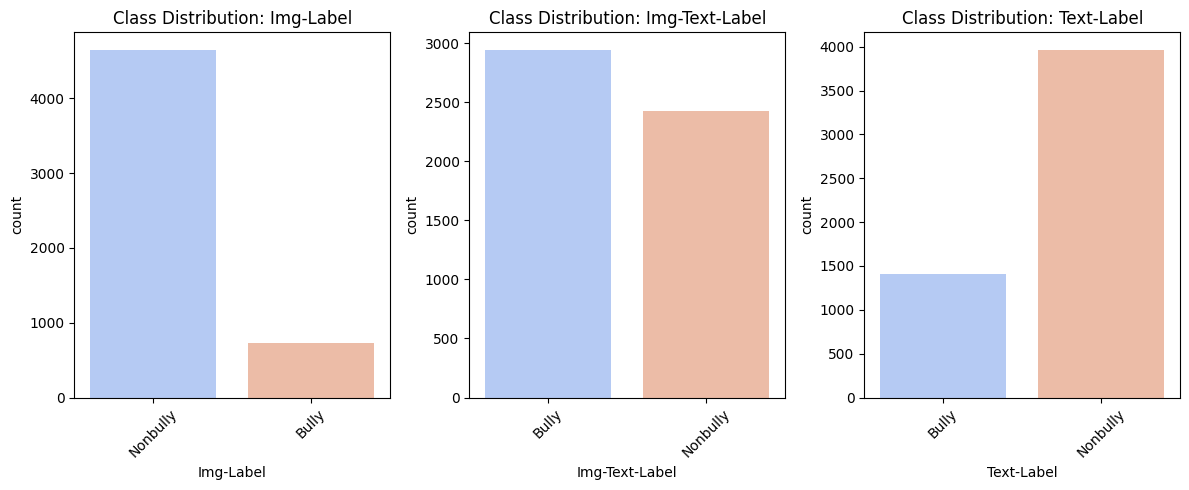

Skipping Word Cloud: 'extracted_text' column is missing or empty.


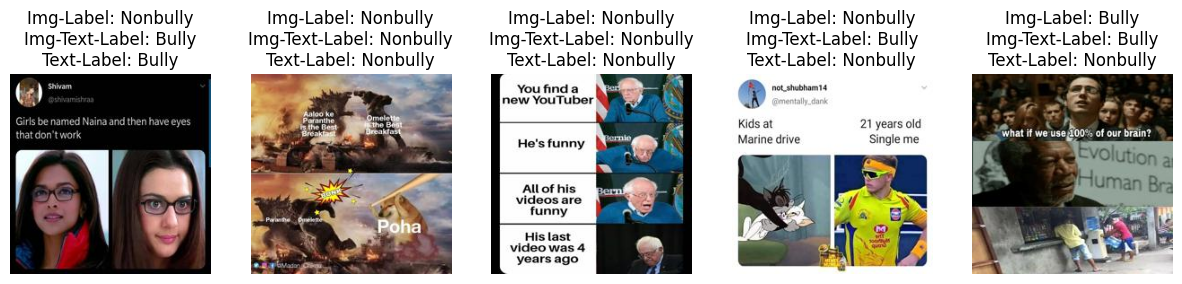

✅ EDA Completed!


In [32]:
# Initialize and run EDA
eda = DataAnalyzer(df)
eda.run_eda()

In [30]:
class TextPreprocessor:
    def __init__(self):
        self.slang_dict = {"u": "you", "lol": "laughing out loud", "brb": "be right back"}
        self.stop_words = set(stopwords.words("english"))
        self.nlp = spacy.load("en_core_web_sm")
        self.suspicious_domains = {"badsite.com", "malwarepage.net", "phishingsite.org"}  # Example blacklist

    def expand_contractions(self, text):
        return contractions.fix(text)

    def correct_spelling(self, text):
        return str(TextBlob(text).correct())

    def clean_whitespace(self, text):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'([!?.,]){2,}', r'\1', text)
        return text.strip()

    def convert_emojis(self, text):
        return emoji.demojize(text)

    def replace_slang(self, text):
        words = text.split()
        return " ".join([self.slang_dict[word] if word in self.slang_dict else word for word in words])

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r"http\S+|www\S+", "", text)
        text = re.sub(r"@[A-Za-z0-9_]+", "", text)
        text = re.sub(r"#[A-Za-z0-9_]+", "", text)
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        return text.strip()

    def remove_stopwords(self, text):
        words = word_tokenize(text)
        return " ".join([word for word in words if word not in self.stop_words])

    def lemmatize_text(self, text):
        doc = self.nlp(text)
        return " ".join([token.lemma_ for token in doc])

    def extract_domain(self, text):
        if not isinstance(text, str):
            return []
        urls = re.findall(r'www\.[a-zA-Z0-9.-]+', text)
        domains = [urlparse("http://" + url).netloc for url in urls]
        return domains

    def is_suspicious_domain(self, domain_list):
        return any(domain in self.suspicious_domains for domain in domain_list)

    def preprocess(self, df, column="Img-Text"):
        """Run all preprocessing steps including Hindi transliteration."""
        df[column] = df[column].fillna("").astype(str)
        df[column] = df[column].apply(self.expand_contractions)
        df[column] = df[column].apply(self.clean_whitespace)
        df[column] = df[column].apply(self.convert_emojis)
        df[column] = df[column].apply(self.replace_slang)
        df[column] = df[column].apply(self.clean_text)
        df[column] = df[column].apply(self.remove_stopwords)
        df[column] = df[column].apply(self.lemmatize_text)
        return df

In [31]:
# Initialize Preprocessor
text_preprocessor = TextPreprocessor()


In [33]:
df['Img-Text'] = df['Img-Text'].fillna("")
df = text_preprocessor.preprocess(df, column="Img-Text")
df["domains"] = df["Img-Text"].apply(text_preprocessor.extract_domain)
df["is_suspicious"] = df["domains"].apply(text_preprocessor.is_suspicious_domain)

In [34]:
df["Img-Text"]

,Img-Text
0,shivam girl name naina eye work
1,aaloo ke paranthe good breakfast omelette good...
2,boyfriend bestfriend desi adukt troll
3,find new youtuber funny video funny last video...
4,notshubham14 kids marine drive 21 year single
...,...
5380,decent kid section
5381,reply everyone instantly know much hurt someon...
5382,girl read desi adult troll meme
5383,jumping would solve problem


In [35]:
print("✅ Text Preprocessing & URL Analysis Integrated in Class!")

✅ Text Preprocessing & URL Analysis Integrated in Class!


In [39]:
# Ensure the column with image names exists
if "Img-Name" not in df.columns:
    raise KeyError("Column 'Img-Name' not found in dataset")

# Check if each image exists
df["image_exists"] = df["Img-Name"].apply(lambda img: os.path.exists(os.path.join(IMAGE_FOLDER, str(img))) if pd.notna(img) else False)

# Remove rows where images do not exist
df = df[df["image_exists"]].drop(columns=["image_exists"]).reset_index(drop=True)

print(f"Dataset cleaned! Remaining rows: {len(df)}")

Dataset cleaned! Remaining rows: 5375


In [37]:
class ImagePreprocessor:
    def __init__(self):
        pass

    def convert_to_grayscale(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    def apply_threshold(self, image):
        _, thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thresh

    def remove_noise(self, image):
        return cv2.fastNlMeansDenoising(image, h=30)

    def apply_morphology(self, image):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    def apply_canny_edge(self, image):
        return cv2.Canny(image, 100, 200)

    def preprocess(self, image_path):
        image = cv2.imread(image_path)
        image = self.convert_to_grayscale(image)
        image = self.apply_threshold(image)
        image = self.remove_noise(image)
        image = self.apply_morphology(image)
        image = self.apply_canny_edge(image)
        return Image.fromarray(image)

In [38]:
# Initialize Image Preprocessor
image_preprocessor = ImagePreprocessor()

In [ ]:
for image_name in os.listdir(IMAGE_FOLDER):
    image_path = os.path.join(IMAGE_FOLDER, image_name)

    try:
        preprocessed_image = image_preprocessor.preprocess(image_path)
        preprocessed_image.save(os.path.join(OUTPUT_FOLDER, image_name))  # Save the preprocessed image
        print(f"Processed: {image_name}")
    except Exception as e:
        print(f"Error processing {image_name}: {e}")

In [ ]:
print("✅ Image Preprocessing Integrated!")

In [ ]:
class TextExtractor:
    def __init__(self):
        self.processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
        self.model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

    def extract_text_tesseract(self, image):
        return pytesseract.image_to_string(image, lang='eng')

    def extract_text_trocr(self, image):
        image = self.processor(image, return_tensors="pt").pixel_values
        generated_ids = self.model.generate(image)
        return self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    def extract_text(self, image_path):
        image = Image.open(image_path)
        text_tesseract = self.extract_text_tesseract(image)
        text_trocr = self.extract_text_trocr(image)
        return text_tesseract + " " + text_trocr

In [ ]:
# Initialize Text Extractor
text_extractor = TextExtractor()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

In [ ]:
df["extracted_text"] = df["image_path"].apply(text_extractor.extract_text)

TesseractNotFoundError: /usr/bin/tesseract is not installed or it's not in your PATH. See README file for more information.

In [ ]:
print("Text Extraction, Preprocessing, and Merging Completed!")

In [ ]:
# Convert Domains into Machine Learning Features
vectorizer = CountVectorizer()
domain_features = vectorizer.fit_transform(df['domains'].astype(str))

In [ ]:
# Remove ScoopWhoop URLs from text
df["Img-Text"] = df["Img-Text"].apply(lambda x: re.sub(r'\bSCOOPWHOOP\.com\b', '', x, flags=re.IGNORECASE))

In [ ]:
# Run EDA after preprocessing
eda_post = DataAnalyzer(df)
eda_post.run_eda()

In [ ]:
# Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Text Feature Extraction
vectorizer = TfidfVectorizer()
fasttext_model = FastText(sentences=df['cleaned_text'].apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def analyze_text(text):
    tfidf_features = vectorizer.fit_transform([text]).toarray()
    fasttext_vector = np.mean([fasttext_model.wv[word] for word in text.split() if word in fasttext_model.wv] or [np.zeros(100)], axis=0)
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        bert_features = bert_model(**inputs).pooler_output.squeeze(0).numpy()
    return tfidf_features, fasttext_vector, bert_features